In [1]:
from texture.datasets import FMDDataset, DatasetSequence
from texture.networks import diception_net
from imgaug import augmenters as iaa

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [2]:
fmd_dataset = FMDDataset('/home/ross/Dropbox/benchmark/FlickrMaterials/', input_size=300)
fmd_dataset.load_or_generate_data()

['fabric', 'foliage', 'glass', 'leather', 'metal', 'paper', 'plastic', 'stone', 'water', 'wood']


/home/ross/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [3]:
print(fmd_dataset)

FMD Dataset
Num classes: 10
Random seed: None
Input shape: (300, 300, 3)



In [4]:
aug_seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Affine(scale=(0.75, 1.25),
               translate_percent=(-1., 1.),
               mode='wrap'),
    #iaa.Sharpen(alpha=(0.0,0.25), lightness=(0.9, 1.1)),
    #iaa.Invert(0.5)
    #iaa.CoarseDropout((0.0, 0.25), size_percent=(0.02, 0.2))
])

def train_batch_aug(batch_X, batch_y):
    return aug_seq.augment_images(batch_X), batch_y

In [5]:
from keras.applications import vgg19

In [6]:
vgg = vgg19.VGG19(include_top=False)

for layer in vgg.layers:
    print(layer.name, [w.shape for w in layer.weights])

input_1 []
block1_conv1 [TensorShape([Dimension(3), Dimension(3), Dimension(3), Dimension(64)]), TensorShape([Dimension(64)])]
block1_conv2 [TensorShape([Dimension(3), Dimension(3), Dimension(64), Dimension(64)]), TensorShape([Dimension(64)])]
block1_pool []
block2_conv1 [TensorShape([Dimension(3), Dimension(3), Dimension(64), Dimension(128)]), TensorShape([Dimension(128)])]
block2_conv2 [TensorShape([Dimension(3), Dimension(3), Dimension(128), Dimension(128)]), TensorShape([Dimension(128)])]
block2_pool []
block3_conv1 [TensorShape([Dimension(3), Dimension(3), Dimension(128), Dimension(256)]), TensorShape([Dimension(256)])]
block3_conv2 [TensorShape([Dimension(3), Dimension(3), Dimension(256), Dimension(256)]), TensorShape([Dimension(256)])]
block3_conv3 [TensorShape([Dimension(3), Dimension(3), Dimension(256), Dimension(256)]), TensorShape([Dimension(256)])]
block3_conv4 [TensorShape([Dimension(3), Dimension(3), Dimension(256), Dimension(256)]), TensorShape([Dimension(256)])]
block3_

[[1, 2, 3, 4], [1, 2, 3, 4], [1, 2, 3, 4], [1, 2, 3, 4]]
input_1 []
entry_3x3_1 [TensorShape([Dimension(3), Dimension(3), Dimension(3), Dimension(32)]), TensorShape([Dimension(32)])]
entry_3x3_2 [TensorShape([Dimension(3), Dimension(3), Dimension(32), Dimension(64)]), TensorShape([Dimension(64)])]
block_48_1x1_1 [TensorShape([Dimension(1), Dimension(1), Dimension(64), Dimension(48)]), TensorShape([Dimension(48)])]
block_48_1x1_2 [TensorShape([Dimension(1), Dimension(1), Dimension(64), Dimension(48)]), TensorShape([Dimension(48)])]
block_48_1x1_3 [TensorShape([Dimension(1), Dimension(1), Dimension(64), Dimension(48)]), TensorShape([Dimension(48)])]
block_48_1x1_4 [TensorShape([Dimension(1), Dimension(1), Dimension(64), Dimension(48)]), TensorShape([Dimension(48)])]
block_48_dilate_1 [TensorShape([Dimension(3), Dimension(3), Dimension(48), Dimension(48)]), TensorShape([Dimension(48)])]
block_48_dilate_2 [TensorShape([Dimension(3), Dimension(3), Dimension(48), Dimension(48)]), TensorShape

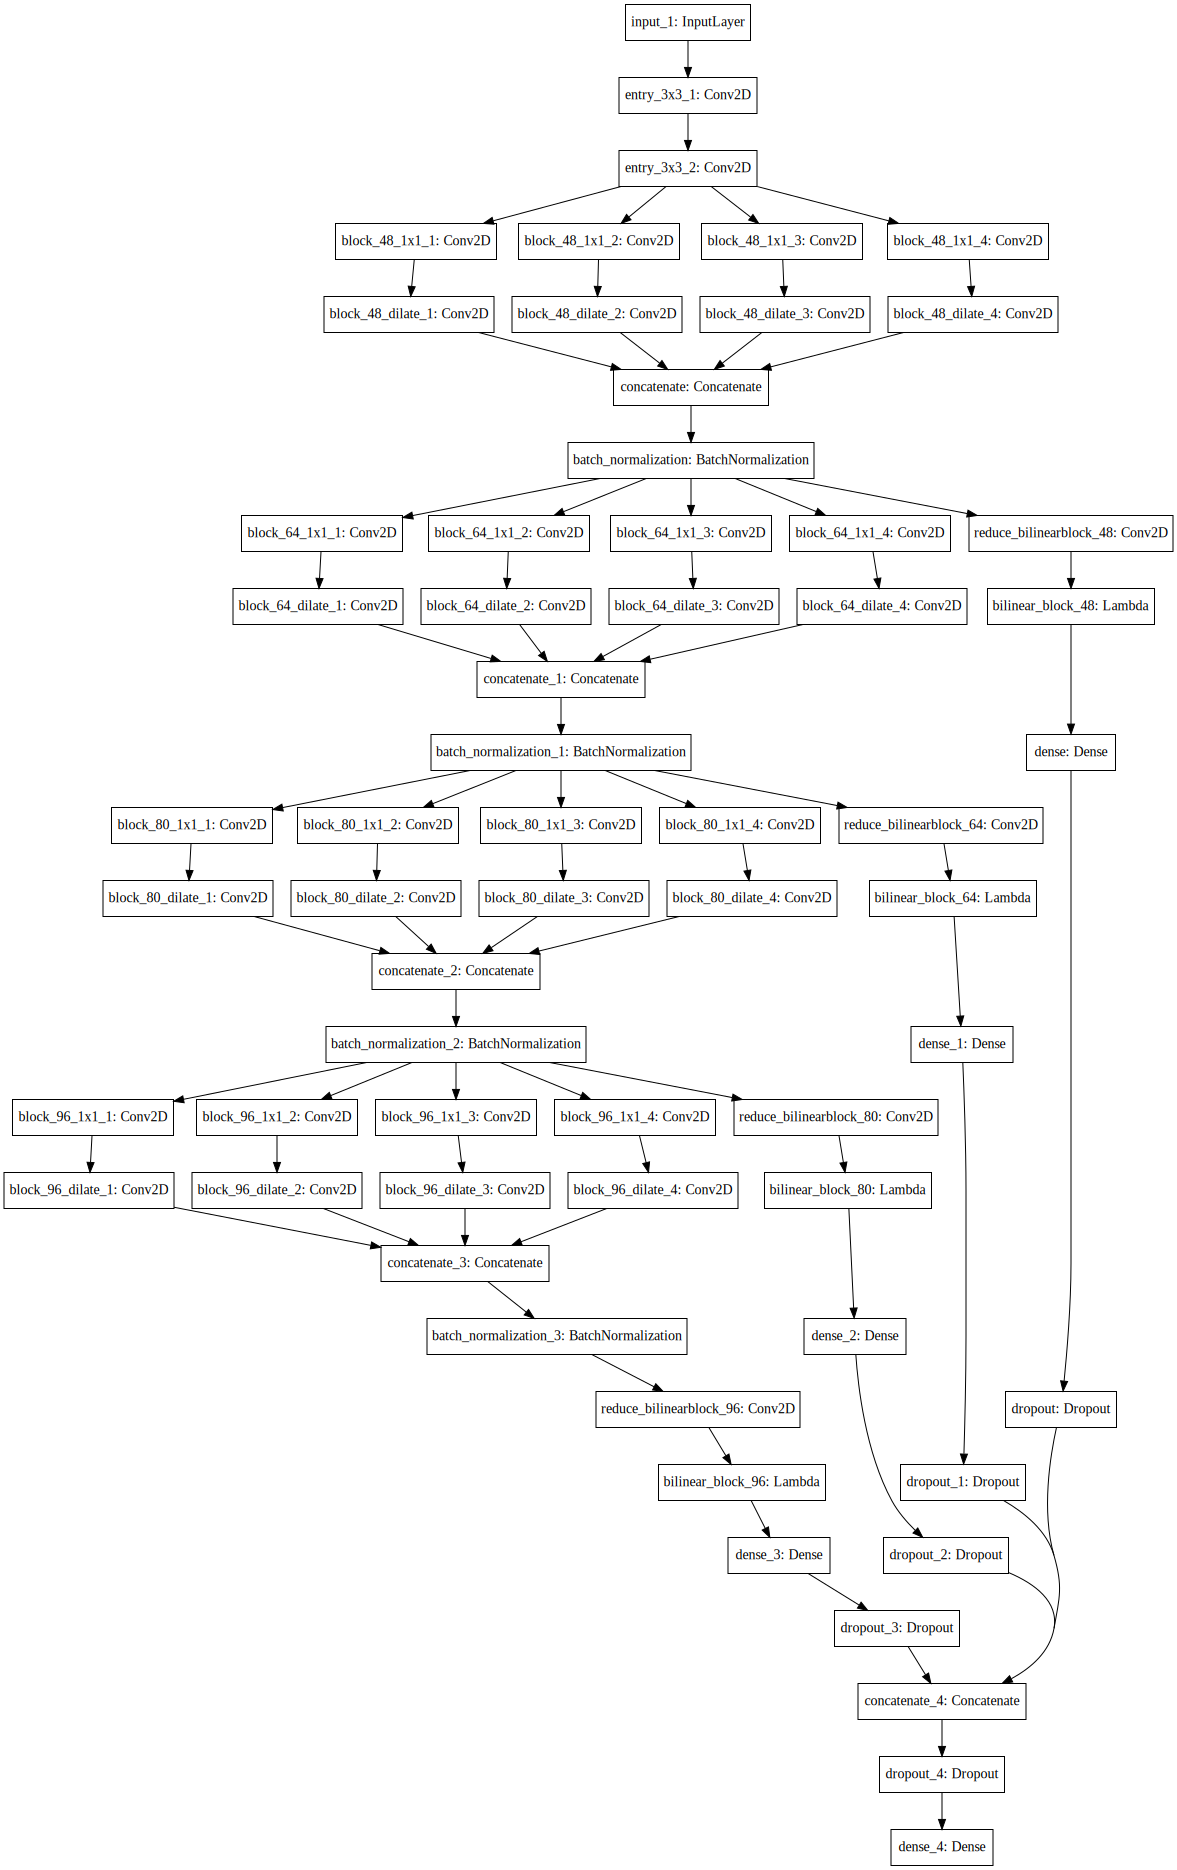

In [7]:
diception_bilinear = diception_net(10, (300,300,3),
                                  entry_conv=64,
                                  blocks=[48,64,80,96],
                                  pooling_args={'bilinear': {'conv1x1': 64}},
                                  pooling_features=64,
                                  dropout_rate=0.33)

for layer in diception_bilinear.layers:
    print(layer.name, [w.shape for w in layer.weights])

diception_bilinear.summary()

SVG(model_to_dot(diception_bilinear).create(prog='dot', format='svg'))

In [11]:
from tensorflow.keras.optimizers import Adam

batch_size = 16
epochs = 30


train_gen = DatasetSequence(fmd_dataset.X_train, fmd_dataset.y_train, batch_size=batch_size, augment_fn=train_batch_aug)
test_gen = DatasetSequence(fmd_dataset.X_test, fmd_dataset.y_test, batch_size=batch_size)


adam_opt = Adam()

diception_bilinear.compile(adam_opt, loss='categorical_crossentropy', metrics=['accuracy'])

diception_bilinear.fit_generator(train_gen, epochs=epochs, validation_data=test_gen, shuffle=False)

Epoch 1/30
57/57 [==============================] - 29s 501ms/step - loss: 2.2371 - acc: 0.1667 - val_loss: 2.2646 - val_acc: 0.1700
Epoch 2/30
57/57 [==============================] - 17s 293ms/step - loss: 2.1124 - acc: 0.2171 - val_loss: 2.2626 - val_acc: 0.1600
Epoch 3/30
57/57 [==============================] - 18s 308ms/step - loss: 2.0823 - acc: 0.2215 - val_loss: 2.0925 - val_acc: 0.2100
Epoch 4/30
57/57 [==============================] - 17s 296ms/step - loss: 2.0301 - acc: 0.2401 - val_loss: 2.0611 - val_acc: 0.2200
Epoch 5/30
57/57 [==============================] - 17s 297ms/step - loss: 2.0095 - acc: 0.2654 - val_loss: 1.9964 - val_acc: 0.2600
Epoch 6/30
57/57 [==============================] - 17s 297ms/step - loss: 2.0012 - acc: 0.2786 - val_loss: 1.9780 - val_acc: 0.2700
Epoch 7/30
57/57 [==============================] - 17s 295ms/step - loss: 1.9494 - acc: 0.2927 - val_loss: 2.0679 - val_acc: 0.2200
Epoch 8/30
57/57 [==============================] - 17s 298ms/step - 

In [25]:
# increased conv1x1, decreased pooling_features

diception_bilinear = diception_net(10, (300,300,3),
                                  entry_conv=64,
                                  dilation_rates=[[1,2,3,4,5],[1,2,3,4], [1,2,3],[1,2]],
                                  blocks=[32,64,96,128],
                                  pooling_args={'bilinear': {'conv1x1': 64}},
                                  pooling_features=64,
                                  dropout_rate=0.33)

diception_bilinear.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
entry_3x3_1 (Conv2D)            (None, 300, 300, 32) 896         input_8[0][0]                    
__________________________________________________________________________________________________
entry_3x3_2 (Conv2D)            (None, 300, 300, 64) 18496       entry_3x3_1[0][0]                
__________________________________________________________________________________________________
block_32_1x1_1 (Conv2D)         (None, 150, 150, 32) 2080        entry_3x3_2[0][0]                
__________________________________________________________________________________________________
block_32_1

In [26]:
adam_opt = Adam()

diception_bilinear.compile(adam_opt, loss='categorical_crossentropy', metrics=['accuracy'])

diception_bilinear.fit_generator(train_gen, epochs=epochs, validation_data=test_gen, shuffle=False)

Epoch 1/30
57/57 [==============================] - 25s 437ms/step - loss: 2.2916 - acc: 0.1393 - val_loss: 2.2689 - val_acc: 0.1600
Epoch 2/30
57/57 [==============================] - 15s 272ms/step - loss: 2.1986 - acc: 0.2017 - val_loss: 2.3241 - val_acc: 0.1200
Epoch 3/30
57/57 [==============================] - 16s 278ms/step - loss: 2.1404 - acc: 0.2138 - val_loss: 2.2143 - val_acc: 0.2100
Epoch 4/30
57/57 [==============================] - 16s 279ms/step - loss: 2.0824 - acc: 0.2412 - val_loss: 2.2013 - val_acc: 0.1600
Epoch 5/30
57/57 [==============================] - 16s 279ms/step - loss: 2.0887 - acc: 0.2215 - val_loss: 2.0771 - val_acc: 0.2300
Epoch 6/30
57/57 [==============================] - 16s 279ms/step - loss: 2.0607 - acc: 0.2325 - val_loss: 2.0323 - val_acc: 0.2400
Epoch 7/30
57/57 [==============================] - 16s 279ms/step - loss: 2.0391 - acc: 0.2468 - val_loss: 2.0937 - val_acc: 0.2400
Epoch 8/30
57/57 [==============================] - 16s 279ms/step - 

reduce_bilinearblock_48
[[-0.04115081  0.1796066   0.04529207 ... -0.01980982  0.06751971
  -0.09056473]
 [-0.15640602  0.08637785  0.09664711 ...  0.07651518  0.01235592
  -0.01935456]
 [-0.02868898  0.0111176   0.03210637 ... -0.17417745  0.03099921
   0.06483841]
 ...
 [ 0.16012028 -0.10350522 -0.05838384 ...  0.04036028  0.12938732
  -0.09954611]
 [ 0.18188478 -0.01463723 -0.09186187 ... -0.06472412 -0.07979329
  -0.12296241]
 [-0.08231509 -0.02822375 -0.17005718 ...  0.08679809  0.0181879
   0.07270144]]


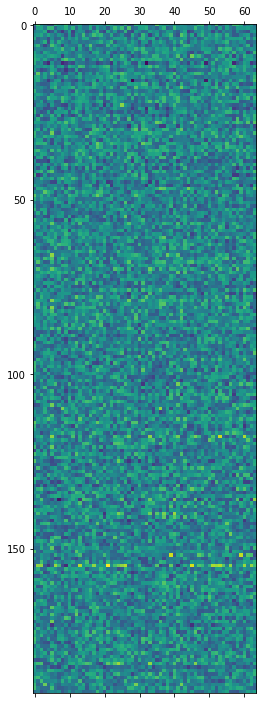

reduce_bilinearblock_64
[[-0.08458503 -0.06954993  0.18856253 ...  0.07325116  0.02161925
  -0.00835443]
 [ 0.23669238  0.06769411 -0.02639789 ... -0.01963693  0.20549762
   0.11221831]
 [ 0.04167398  0.05871068  0.09833695 ... -0.04682402 -0.07424097
  -0.06615621]
 ...
 [-0.01500936  0.09751875  0.07747272 ...  0.09505584  0.1529557
  -0.15626311]
 [ 0.12008075  0.07022355 -0.03543374 ...  0.07327309  0.04100916
  -0.10310081]
 [-0.0989909   0.10390615  0.01411228 ... -0.08837438  0.05326674
  -0.04283685]]


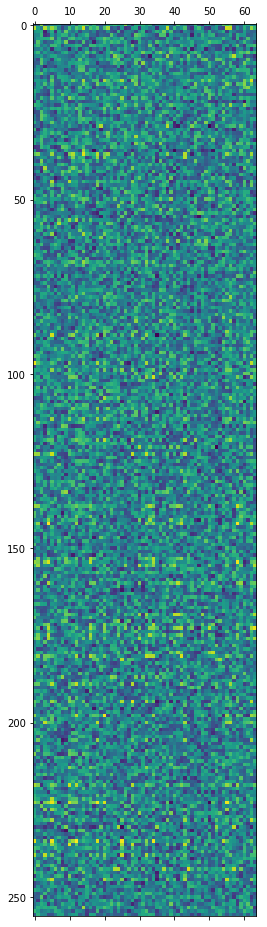

reduce_bilinearblock_80
[[-0.09962166  0.08145673  0.08008239 ... -0.10146968 -0.0726561
  -0.06272206]
 [-0.00245293 -0.11377195 -0.08690394 ...  0.07662009 -0.04724154
  -0.00548086]
 [ 0.02242073 -0.06041658  0.03332046 ... -0.11133126  0.1078043
   0.11038875]
 ...
 [ 0.20013307  0.00858569  0.05673827 ...  0.02500671 -0.20915173
   0.09217517]
 [ 0.10580549  0.09659947  0.17105545 ...  0.02966665 -0.04078891
   0.10292092]
 [ 0.00511819 -0.14464054 -0.04208087 ... -0.07564091 -0.05495442
  -0.00480139]]


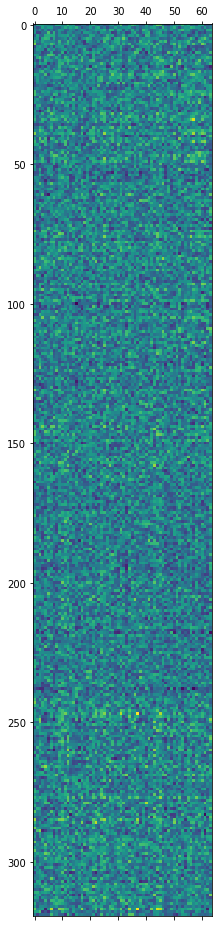

reduce_bilinearblock_96
[[ 0.03876218 -0.09556099  0.04427367 ...  0.00533501  0.05329559
   0.01714399]
 [-0.07463734 -0.00541134 -0.0337298  ...  0.07315569  0.05088044
   0.17351772]
 [ 0.01591413  0.08147686  0.02577714 ... -0.1667674   0.07321511
  -0.06088902]
 ...
 [-0.02870348 -0.06604221  0.01106513 ... -0.11600186 -0.01967718
   0.0539924 ]
 [-0.13185875  0.07448342 -0.1345933  ... -0.12443176 -0.02545367
   0.10789606]
 [ 0.13759062  0.0618819   0.11872725 ... -0.05497665  0.00227087
   0.00861741]]


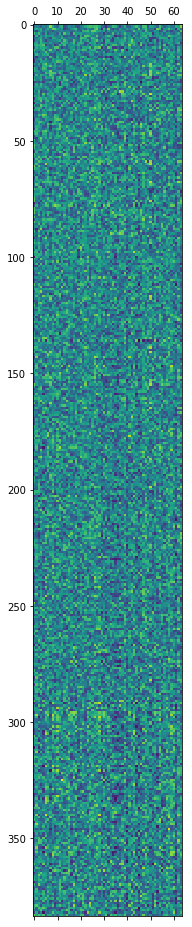

In [21]:
import numpy as np

for layer in diception_bilinear.layers:
    if 'reduce_bilinear' in layer.name:
        print(layer.name)
        plt.matshow(layer.get_weights()[0][0,0,:,:].T)
        plt.show()